# به نام خدا 

# فاز یک


In [4]:
import os
import cv2
import numpy as np
import pandas as pd

In [5]:


# تنظیمات مسیرها و پارامترها
dataset_path = "train"  # مسیر اصلی دیتاست
output_csv = os.path.join(os.getcwd(), "image_features_12.csv")  # مسیر ذخیره فایل خروجی
classes = ["beach", "dense_residential", "desert", "forest", "intersection", "sea_ice"]  # لیست کلاس‌های تصاویر

def extract_features(image):
    """
    استخراج 12 ویژگی از تصویر بر اساس رنگ و بافت
    
    پارامترهای ورودی:
        image: آرایه numpy از تصویر در فرمت RGB
        
    خروجی:
        لیست 12 ویژگی به ترتیب زیر:
        [میانگین قرمز، میانگین سبز، میانگین آبی، 
         واریانس قرمز، واریانس سبز، واریانس آبی،
         انحراف معیار قرمز، انحراف معیار سبز، انحراف معیار آبی،
         نسبت قرمز به سبز، نسبت سبز به آبی، نسبت قرمز به آبی]
    """
    # 1. ویژگی‌های آماری کانال‌های رنگی
    # میانگین رنگ‌ها - نشان دهنده غلظت کلی هر رنگ در تصویر
    mean_r = np.mean(image[:,:,0])  # میانگین کانال قرمز
    mean_g = np.mean(image[:,:,1])  # میانگین کانال سبز
    mean_b = np.mean(image[:,:,2])  # میانگین کانال آبی
    
    # واریانس رنگ‌ها - نشان دهنده میزان پراکندگی مقادیر پیکسل‌ها
    var_r = np.var(image[:,:,0])  # واریانس کانال قرمز
    var_g = np.var(image[:,:,1])  # واریانس کانال سبز
    var_b = np.var(image[:,:,2])  # واریانس کانال آبی
    
    # انحراف معیار رنگ‌ها - نشان دهنده میزان تغییرات رنگ
    std_r = np.std(image[:,:,0])  # انحراف معیار کانال قرمز
    std_g = np.std(image[:,:,1])  # انحراف معیار کانال سبز
    std_b = np.std(image[:,:,2])  # انحراف معیار کانال آبی
    
    # 2. ویژگی‌های نسبتی - نشان دهنده تعادل بین رنگ‌ها
    ratio_rg = mean_r / (mean_g + 1e-5)  # نسبت قرمز به سبز (برای جلوگیری از تقسیم بر صفر 1e-5 اضافه شده)
    ratio_gb = mean_g / (mean_b + 1e-5)  # نسبت سبز به آبی
    ratio_rb = mean_r / (mean_b + 1e-5)  # نسبت قرمز به آبی
    
    return [mean_r, mean_g, mean_b, 
            var_r, var_g, var_b,
            std_r, std_g, std_b,
            ratio_rg, ratio_gb, ratio_rb]

def process_image(image_path):
    """
    خواندن تصویر و آماده‌سازی آن برای استخراج ویژگی‌ها
    
    پارامترهای ورودی:
        image_path: مسیر کامل فایل تصویر
        
    خروجی:
        لیست ویژگی‌های استخراج شده یا None در صورت بروز خطا
    """
    try:
        # خواندن تصویر از دیسک
        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ خطا در خواندن تصویر: {image_path}")
            return None
        
        # تبدیل رنگ از BGR (پیش‌فرض OpenCV) به RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return extract_features(image)
    except Exception as e:
        print(f"خطا در پردازش {image_path}: {str(e)}")
        return None

# بخش اصلی کد - پردازش تمام تصاویر دیتاست
data = []  # لیست برای ذخیره اطلاعات تمام تصاویر

# پردازش هر کلاس از تصاویر
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_path):
        print(f"⚠️ پوشه {class_path} وجود ندارد!")
        continue  
        
    # پردازش هر تصویر در پوشه کلاس
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file) 
        
        features = process_image(img_path)
        
        # اگر ویژگی‌ها با موفقیت استخراج شدند
        if features is not None:
            data.append({
                "class": class_name,  # نام کلاس تصویر
                "filename": img_file,  # نام فایل تصویر
                
                # ویژگی‌های رنگی
                "mean_r": features[0],  # میانگین کانال قرمز
                "mean_g": features[1],  # میانگین کانال سبز
                "mean_b": features[2],  # میانگین کانال آبی
                
                # ویژگی‌های پراکندگی رنگ
                "var_r": features[3],  # واریانس کانال قرمز
                "var_g": features[4],  # واریانس کانال سبز
                "var_b": features[5],  # واریانس کانال آبی
                
                # ویژگی‌های تغییرات رنگ
                "std_r": features[6],  # انحراف معیار کانال قرمز
                "std_g": features[7],  # انحراف معیار کانال سبز
                "std_b": features[8],  # انحراف معیار کانال آبی
                
                # ویژگی‌های نسبتی
                "ratio_rg": features[9],  # نسبت قرمز به سبز
                "ratio_gb": features[10],  # نسبت سبز به آبی
                "ratio_rb": features[11]  # نسبت قرمز به آبی
            })

# ذخیره نتایج در فایل CSV
if data: 
    try:
        df = pd.DataFrame(data)
        df.to_csv(output_csv, index=False)
        
        # نمایش گزارش نهایی
        print(f"✅ ویژگی‌های استخراج شده در {output_csv} ذخیره شدند.")
        print(f"تعداد تصاویر پردازش شده: {len(df)}")
        print(f"تعداد ویژگی‌های هر تصویر: 12")
        
    except PermissionError:
        print("❌ خطای دسترسی! لطفاً:")
        print("1. فایل خروجی را اگر باز است ببندید")
        print("2. مسیر ذخیره متفاوتی انتخاب کنید")
        print(f"مسیر پیشنهادی: {os.path.join(os.path.expanduser('~'), 'Desktop')}")
else:
    print("❌ هیچ داده‌ای پردازش نشد!")

✅ ویژگی‌های استخراج شده در d:\University\project\hoshMohasebaty\Clustering\image_features_12.csv ذخیره شدند.
تعداد تصاویر پردازش شده: 3600
تعداد ویژگی‌های هر تصویر: 12


# فاز دو

In [7]:
import pandas as pd
import numpy as np

In [9]:


# خواندن داده‌های فاز اول با 12 ویژگی
df = pd.read_csv("image_features_12.csv")

# تابع محاسبه همبستگی (پیاده‌سازی دستی)
def calculate_correlation(x, y):
    """
    محاسبه ضریب همبستگی پیرسون بین دو ویژگی
    ورودی:
        x, y: دو آرایه numpy از ویژگی‌های مورد مقایسه
    خروجی:
        مقدار ضریب همبستگی بین دو ویژگی
    """
    covariance = np.cov(x, y, bias=True)[0, 1]
    std_x = np.std(x)
    std_y = np.std(y)
    return covariance / (std_x * std_y)

# ایجاد ماتریس همبستگی
def create_correlation_matrix(features):
    """
    ایجاد ماتریس همبستگی بین تمام ویژگی‌ها
    ورودی:
        features: دیتافریم شامل ویژگی‌های عددی
    خروجی:
        corr_matrix: ماتریس همبستگی
        feature_names: لیست نام ویژگی‌ها
    """
    feature_names = features.columns
    n_features = len(feature_names)
    corr_matrix = np.zeros((n_features, n_features))
    
    for i in range(n_features):
        for j in range(n_features):
            corr_matrix[i, j] = calculate_correlation(
                features.iloc[:, i].values,
                features.iloc[:, j].values
            )
    return corr_matrix, feature_names

# تابع انتخاب ویژگی‌های بهینه
def select_optimal_features(corr_matrix, feature_names, n_features=3, threshold=0.7):
    """
    انتخاب ویژگی‌های بهینه بر اساس کمترین همبستگی
    ورودی:
        corr_matrix: ماتریس همبستگی
        feature_names: لیست نام ویژگی‌ها
        n_features: تعداد ویژگی‌های مورد نیاز
        threshold: آستانه همبستگی برای حذف ویژگی‌های مشابه
    خروجی:
        لیست ویژگی‌های انتخاب شده
    """
    selected = []
    remaining = list(feature_names)
    
    while len(selected) < n_features and remaining:
        # محاسبه میانگین همبستگی مطلق هر ویژگی با سایر ویژگی‌ها
        avg_corrs = []
        for i, feat in enumerate(remaining):
            idx = list(feature_names).index(feat)
            avg_corr = np.mean(np.abs([
                corr_matrix[idx][list(feature_names).index(f)] 
                for f in remaining if f != feat
            ]))
            avg_corrs.append(avg_corr)
        
        # انتخاب ویژگی با کمترین میانگین همبستگی
        best_idx = np.argmin(avg_corrs)
        best_feature = remaining.pop(best_idx)
        selected.append(best_feature)
        
        # حذف ویژگی‌های با همبستگی بالا با ویژگی انتخاب شده
        remaining = [
            f for f in remaining 
            if abs(corr_matrix[list(feature_names).index(best_feature)]
                [list(feature_names).index(f)]) <= threshold
        ]
    
    return selected[:n_features]

# محاسبه ماتریس همبستگی برای 12 ویژگی
numeric_features = df.drop(['class', 'filename'], axis=1)
corr_matrix, feature_names = create_correlation_matrix(numeric_features)

# نمایش ماتریس همبستگی به صورت متنی
print("\nماتریس همبستگی بین 12 ویژگی:\n")
print("            " + " ".join([f"{name[:10]:>10}" for name in feature_names]))
for i, name in enumerate(feature_names):
    row = [f"{corr:.2f}" for corr in corr_matrix[i]]
    print(f"{name[:10]:>10} " + " ".join([f"{val:>10}" for val in row]))

# انتخاب خودکار 3 ویژگی بهینه
optimal_features = select_optimal_features(corr_matrix, feature_names)
print("\n سه ویژگی بهینه انتخاب شده:")
for i, feat in enumerate(optimal_features, 1):
    print(f"{i}. {feat}")

# ذخیره نتایج
selected_df = df[['class', 'filename'] + optimal_features]
selected_df.to_csv('selected_features_12.csv', index=False)
print("\nنتایج در selected_features_12.csv ذخیره شدند.")


ماتریس همبستگی بین 12 ویژگی:

                mean_r     mean_g     mean_b      var_r      var_g      var_b      std_r      std_g      std_b   ratio_rg   ratio_gb   ratio_rb
    mean_r       1.00       0.97       0.89      -0.05      -0.12      -0.11      -0.13      -0.21      -0.19       0.73       0.14       0.67
    mean_g       0.97       1.00       0.96       0.06      -0.04      -0.02      -0.02      -0.12      -0.10       0.56       0.08       0.50
    mean_b       0.89       0.96       1.00       0.19       0.10       0.13       0.13       0.04       0.07       0.49      -0.18       0.29
     var_r      -0.05       0.06       0.19       1.00       0.94       0.89       0.97       0.92       0.88      -0.12      -0.41      -0.33
     var_g      -0.12      -0.04       0.10       0.94       1.00       0.97       0.93       0.97       0.95      -0.13      -0.44      -0.37
     var_b      -0.11      -0.02       0.13       0.89       0.97       1.00       0.89       0.95       0.97 

# فاز سه

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import joblib


In [24]:

# 1. آماده‌سازی داده‌ها
try:
    # بارگذاری داده‌ها از فایل CSV
    data = pd.read_csv('selected_features_12.csv')
    
    # حذف ستون‌های 'class' و 'filename' از داده‌ها
    features = data.drop(['class', 'filename'], axis=1)
    
    # فرض بر اینکه همه ویژگی‌ها بهینه هستند
    optimal_features = features.columns.tolist()  
    features = features[optimal_features]

    # نرمال‌سازی داده‌ها با استفاده از StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

except FileNotFoundError:
    print("فایل 'selected_features_12.csv' پیدا نشد.")
except Exception as e:
    print(f"خطا در آماده‌سازی داده‌ها: {e}")

# 2. تنظیم هایپرپارامترها و خوشه‌بندی
# الف) K-Means
print("\n--- خوشه‌بندی K-Means ---")
param_grid_kmeans = {
    'n_clusters': range(2, 11),  # تعداد خوشه‌ها از 2 تا 10
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500]
}

best_kmeans = None
best_score = -1

for n_clusters in param_grid_kmeans['n_clusters']:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    
    if score > best_score:
        best_score = score
        best_kmeans = kmeans

data['kmeans_cluster'] = best_kmeans.fit_predict(X_scaled)

# ذخیره مدل K-Means
joblib.dump(best_kmeans, 'best_kmeans_model.joblib')

print(f"بهترین تعداد خوشه‌ها برای K-Means: {best_kmeans.n_clusters}")

# ب) DBSCAN
print("\n--- خوشه‌بندی DBSCAN ---")
# تعیین بهترین eps با استفاده از Nearest Neighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, 1], axis=0)

# انتخاب eps و min_samples به صورت دستی
eps = 0.5  # مقدار مناسب eps را بر اساس تحلیل انتخاب کنید
min_samples = 5  # مقدار min_samples را نیز انتخاب کنید

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)
data['dbscan_cluster'] = dbscan_labels

# ذخیره مدل DBSCAN
joblib.dump(dbscan, 'dbscan_model.joblib')

# ج) Agglomerative Clustering
print("\n--- خوشه‌بندی Agglomerative ---")
agg = AgglomerativeClustering(n_clusters=best_kmeans.n_clusters, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)
data['agg_cluster'] = agg_labels

# ذخیره مدل Agglomerative
joblib.dump(agg, 'agg_model.joblib')

# د) MeanShift
print("\n--- خوشه‌بندی MeanShift ---")
meanshift = MeanShift(bandwidth=0.9)
meanshift_labels = meanshift.fit_predict(X_scaled)
data['meanshift_cluster'] = meanshift_labels

# ذخیره مدل MeanShift
joblib.dump(meanshift, 'meanshift_model.joblib')

# 4. مقایسه نتایج
try:
    print("\n--- تعداد خوشه‌ها ---")
    print("K-Means:", pd.Series(data['kmeans_cluster']).value_counts())
    print("DBSCAN:", pd.Series(data['dbscan_cluster']).value_counts())
    print("Agglomerative:", pd.Series(data['agg_cluster']).value_counts())
    print("MeanShift:", pd.Series(data['meanshift_cluster']).value_counts())

except Exception as e:
    print(f"خطا در مقایسه نتایج: {e}")



--- خوشه‌بندی K-Means ---
بهترین تعداد خوشه‌ها برای K-Means: 3

--- خوشه‌بندی DBSCAN ---

--- خوشه‌بندی Agglomerative ---

--- خوشه‌بندی MeanShift ---

--- تعداد خوشه‌ها ---
K-Means: kmeans_cluster
1    2279
0     681
2     640
Name: count, dtype: int64
DBSCAN: dbscan_cluster
 0    3563
-1      24
 1      10
 2       3
Name: count, dtype: int64
Agglomerative: agg_cluster
0    2402
2     639
1     559
Name: count, dtype: int64
MeanShift: meanshift_cluster
0    2232
2     589
1     519
5     122
3      98
4      23
8       9
7       6
6       2
Name: count, dtype: int64


# فاز چهار


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

نام ستون‌ها:
Index(['class', 'filename', 'mean_g', 'ratio_rg', 'ratio_gb', 'kmeans_cluster',
       'dbscan_cluster', 'agg_cluster', 'meanshift_cluster'],
      dtype='object')


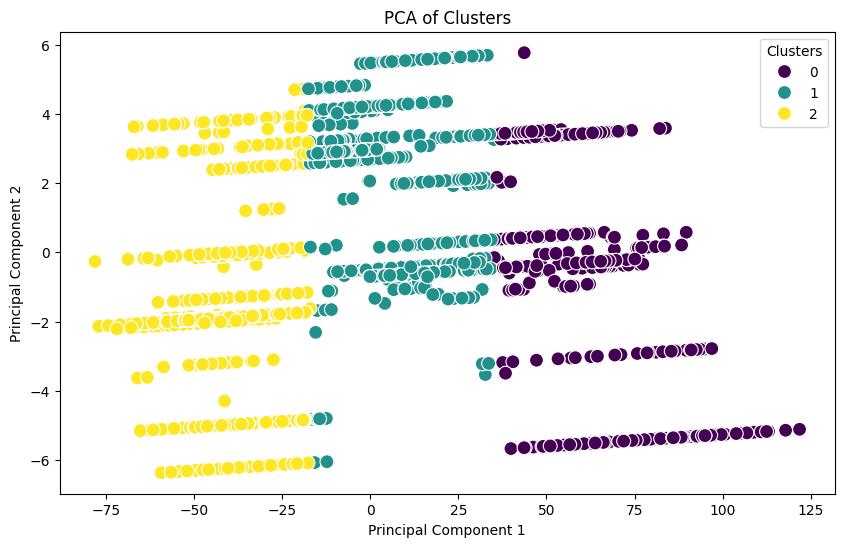

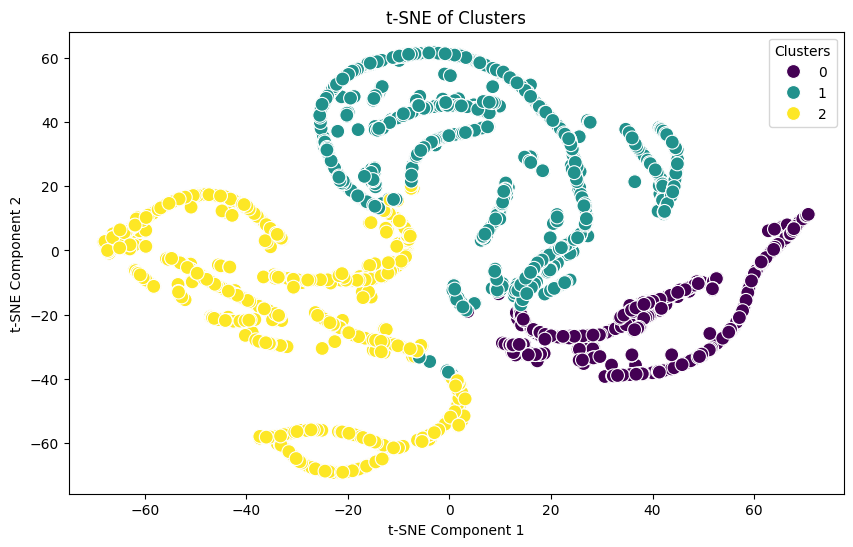

In [17]:


# بارگذاری داده‌ها
data = pd.read_csv('clustering_results.csv')  # نام فایل داده‌های خود را وارد کنید

# نمایش نام ستون‌ها
print("نام ستون‌ها:")
print(data.columns)

# حذف ستون‌های غیرضروری (در صورت وجود)
X = data.drop(columns=['label', 'filename', 'class'], errors='ignore')  # حذف ستون‌های غیرضروری

# خوشه‌بندی با KMeans
kmeans = KMeans(n_clusters=3, random_state=42)  # تعداد خوشه‌ها را تنظیم کنید
clusters = kmeans.fit_predict(X)

# کاهش ابعاد با PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# تجسم خوشه‌ها با PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('PCA of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')
plt.show()

# کاهش ابعاد با t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter_without_progress=300)  # اصلاح پارامتر
X_tsne = tsne.fit_transform(X)

# تجسم خوشه‌ها با t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('t-SNE of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Clusters')
plt.show()


# فاز پنج


In [42]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score

In [43]:


# بارگذاری داده‌ها
data = pd.read_csv('clustering_results.csv')

# نمایش نام ستون‌ها
print("نام ستون‌ها:")
print(data.columns.tolist())

# حذف ستون‌های غیرضروری
X = data.drop(columns=['filename', 'class'], errors='ignore')

# تبدیل برچسب‌های واقعی به عددی
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(data['class'])

# خوشه‌بندی با KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# محاسبه معیارها
precision = precision_score(true_labels, clusters, average='weighted', zero_division=0)
recall = recall_score(true_labels, clusters, average='weighted', zero_division=0)
f1 = f1_score(true_labels, clusters, average='weighted', zero_division=0)
silhouette = silhouette_score(X, clusters)

# گزارش نتایج
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Silhouette Score: {silhouette:.4f}')

# تحلیل تفاوت اعداد خروجی
print("\nتحلیل تفاوت اعداد خروجی:")
print("Precision نشان‌دهنده درصد نمونه‌های مثبت پیش‌بینی‌شده است که واقعاً مثبت هستند.")
print("Recall نشان‌دهنده درصد نمونه‌های مثبت واقعی است که به درستی شناسایی شده‌اند.")
print("F1 Score میانگین هارمونیک precision و recall است که به ما کمک می‌کند تعادل بین این دو را مشاهده کنیم.")
print("Silhouette Score کیفیت خوشه‌ها را نشان می‌دهد و نشان‌دهنده فاصله بین خوشه‌ها است.")


نام ستون‌ها:
['class', 'filename', 'mean_g', 'ratio_rg', 'ratio_gb', 'kmeans_cluster', 'dbscan_cluster', 'agg_cluster', 'meanshift_cluster']
Precision: 0.0874
Recall: 0.1592
F1 Score: 0.1090
Silhouette Score: 0.5756

تحلیل تفاوت اعداد خروجی:
Precision نشان‌دهنده درصد نمونه‌های مثبت پیش‌بینی‌شده است که واقعاً مثبت هستند.
Recall نشان‌دهنده درصد نمونه‌های مثبت واقعی است که به درستی شناسایی شده‌اند.
F1 Score میانگین هارمونیک precision و recall است که به ما کمک می‌کند تعادل بین این دو را مشاهده کنیم.
Silhouette Score کیفیت خوشه‌ها را نشان می‌دهد و نشان‌دهنده فاصله بین خوشه‌ها است.
